In [ ]:
# parameters
grid_size = 3 # size of averaging window for calculating AOD or other products
band = "55"
varPM = "PMc"
varAOD = "nAODm"
root_path = "/content/drive/MyDrive"

# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
from google.colab import drive
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
name = "fAOD_PM" + "_g"+str(grid_size) + "_" + band + ".csv"
path = os.path.join(root_path, "final_data", name)
df = pd.read_csv(path)



X = df[[varAOD, 'lat', 'long', 'Prob_bestm','d2m', 't2m', 'blh',
       'sp', 'lai_hv', 'ws10', 'wd10', 'uvb',
       'RH', 'DOY']]
#X = df[[varAOD, 'lat', 'long', 'Prob_bestm', 'Prob_medm', 'month', 'd2m', 't2m','blh',
 #       'sp', 'lai_hv', 'lai_lv', 'ws10', 'wd10', 'cdir', 'uvb',
   #    'RH', 'DOY']]
#X = df[[varAOD, 'lat', 'long', 'Prob_medm', 'd2m', 't2m',
#       'lai_hv', 'ws10', 'uvb', 'RH', 'DOY']]
print(X.columns)
y = df[[varPM]]
y = y.to_numpy()

scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)
print(Xs.shape)
print(y.shape)

Index(['nAODm', 'lat', 'long', 'Prob_bestm', 'd2m', 't2m', 'blh', 'sp',
       'lai_hv', 'ws10', 'wd10', 'uvb', 'RH', 'DOY'],
      dtype='object')
(19862, 14)
(19862, 1)


In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:

i = 0
for train_index, test_index in cv.split(X):
  print("loop:", i)
  if i == 6:
    print( "TRAIN:", train_index, "TEST:", test_index)
    break
  else:
    i+=1
Xtrain = Xs[train_index]
ytrain = y[train_index]

Xtest = Xs[test_index]
ytest = y[test_index]

print(Xtrain.shape)
print(ytrain.shape)

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4
loop: 5
loop: 6
TRAIN: [    0     4     5 ... 19859 19860 19861] TEST: [    1     2     3 ... 19843 19846 19850]
(17876, 14)
(17876, 1)


In [ ]:
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

save_dir = os.path.join(root_path, "final_data/saved_models")
fold_var = 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
# get the model


def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(1024, input_dim=n_inputs, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(16, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(16, activation='relu', kernel_regularizer=l2(1e-3)))
	model.add(Dense(14, activation='relu', kernel_regularizer=l2(1e-3)))

	model.add(Dense(n_outputs, activation='linear'))
	model.summary()
#	lr_schedule = ExponentialDecay(initial_learning_rate=1e-2,
#   decay_steps=10,
#   decay_rate=0.9)
	opt = Adam(lr=0.0001 )
#	opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#	opt = RMSprop(learning_rate=0.001)
	model.compile(optimizer=opt, loss='mse')
	return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              15360     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               6

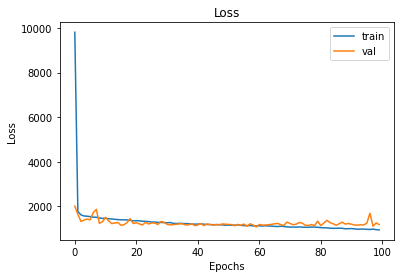

In [ ]:
n_inputs, n_outputs = Xtrain.shape[1], ytrain.shape[1]

model = get_model(n_inputs, n_outputs)
# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_dir, get_model_name(fold_var)),
							monitor='val_loss', verbose=1,
							save_best_only=True, mode='min')

callbacks_list = [checkpoint]


# fit the autoencoder model to reconstruct input
history = model.fit(Xtrain, ytrain, epochs=100, verbose=2, validation_split=0.1, callbacks=callbacks_list)
# plot val and loss
plot_history(history)

In [ ]:
dftest = df.loc[test_index]

# LOAD BEST MODEL to evaluate the performance of the model
#model.load_weights(os.path.join(save_dir, get_model_name(fold_var)))

# prediction on validation data
dftest["y_pred"] = model.predict(Xtest)

def NominalPM(row):
    return row["y_pred"]/((1-row["RH"])**(-1))
dftest["PMp"] = dftest.apply(NominalPM, axis = 1)

print ("RMSE: ", np.round(mean_squared_error(dftest["PMp"], dftest["PM2.5"], squared=False),2))
print ("MAE: ", np.round(mean_absolute_error(dftest["PM2.5"], dftest["PMp"]),2))
from scipy.stats import pearsonr
corr, _ = pearsonr(dftest["y_pred"], dftest["PMc"])
print('Pearsons R2 correlation: %.3f' % corr**2)

Deployment Time

In [ ]:
from keras.models import load_model
# LOAD BEST MODEL to evaluate the performance of the model

save_dir = os.path.join(root_path, "final_data/saved_models")
fold_var = 1
# load model
model = load_model(os.path.join(save_dir, get_model_name(fold_var)))

In [ ]:
import time
start = time.time()
df["y_pred"] = model.predict(Xs)
print("Time of execution:",  (time.time() - start))

Time of execution: 2.4287121295928955


AED regression

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
n_inputs, n_outputs = Xtrain.shape[1], ytrain.shape[1]
# define encoder
visible = Input(shape=(n_inputs,))
e=Dense(1024, activation='relu', kernel_regularizer=l2(1e-3))(visible)
e=Dense(1024, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(e)
e=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(bottleneck)
d=Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(1024, activation='relu', kernel_regularizer=l2(1e-3))(d)
d=Dense(1024, activation='relu', kernel_regularizer=l2(1e-3))(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)




# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='mse')

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_dir, get_model_name(fold_var)),
							monitor='val_loss', verbose=1,
							save_best_only=True, mode='min')

callbacks_list = [checkpoint]


# fit the autoencoder model to reconstruct input
history = model.fit(Xtrain, ytrain, epochs=100, verbose=2, validation_split=0.1, callbacks=callbacks_list)
# plot val and loss
plot_history(history)

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
from sklearn.linear_model import LinearRegression
# encode the train data
X_train_encode = encoder.predict(Xtrain)
# encode the test data
X_test_encode = encoder.predict(Xtest)
# define the model
reg = LinearRegression()
# fit the model on the training set
reg.fit(X_train_encode, ytrain)
# make predictions on the test set
dftest = df.loc[test_index]


# prediction on validation data
dftest["y_pred"] = reg.predict(X_test_encode)

def NominalPM(row):
    return row["y_pred"]/((1-row["RH"])**(-1))
dftest["PMp"] = dftest.apply(NominalPM, axis = 1)

print ("RMSE: ", np.round(mean_squared_error(dftest["PMp"], dftest["PM2.5"], squared=False),2))
print ("MAE: ", np.round(mean_absolute_error(dftest["PM2.5"], dftest["PMp"]),2))
from scipy.stats import pearsonr
corr, _ = pearsonr(dftest["y_pred"], dftest["PMc"])
print('Pearsons R2 correlation: %.3f' % corr**2)

RMSE:  9.3
MAE:  7.1
Pearsons R2 correlation: 0.739
